In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# *Detect whether a face image/video is a live person or a spoof (printed photo / replay on screen / optionally mask).*****

# Inspection cell

In [ ]:
# Fast structured listing up to depth 3 (run in your Kaggle notebook)
from pathlib import Path
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os

ROOTS = [
    Path("/kaggle/input/celeba-spoof-for-face-antispoofing"),
    Path("/kaggle/input/photo-print-attacks-dataset-1k-individuals")
]

IMG_EXTS = (".jpg",".jpeg",".png",".bmp",".tiff")
MAX_SUBFOLDERS = 200  # safety cap

def list_folder(path, max_sub=MAX_SUBFOLDERS):
    if not path.exists():
        print(f"Path not found: {path}\n"); return
    print(f"\n=== ROOT: {path} ===")
    top_children = sorted([p for p in path.iterdir()])
    print("Top-level entries (first 50):")
    for i,c in enumerate(top_children[:50]):
        print(" ", i+1, c.name, "(dir)" if c.is_dir() else "(file)")
    # check immediate subfolders (depth=1)
    checked = 0
    for child in top_children:
        if checked >= max_sub: break
        if child.is_dir():
            checked += 1
            # count images directly inside this child (non-recursive)
            files = [f for f in child.iterdir() if f.is_file() and f.suffix.lower() in IMG_EXTS]
            subdirs = [d for d in child.iterdir() if d.is_dir()]
            print(f"\n-- {child.relative_to(path)} -- images_here: {len(files)} , subdirs: {len(subdirs)}")
            # show up to 3 example image filenames
            for ex in files[:3]:
                print("    img:", ex.name)
            # list up to 6 immediate sub-subfolders and show their image counts (depth=2)
            for j, sd in enumerate(subdirs[:6]):
                imgs_sd = [f for f in sd.iterdir() if f.is_file() and f.suffix.lower() in IMG_EXTS]
                print(f"    subdir: {sd.name} -> images_here: {len(imgs_sd)} (examples: {[f.name for f in imgs_sd[:3]]})")
    # Also detect any large archives at root
    archives = [f for f in path.iterdir() if f.is_file() and f.suffix.lower() in (".zip",".rar",".tar",".gz")]
    if archives:
        print("\nArchives found at root:")
        for a in archives:
            print(" ", a.name, "-", a.stat().st_size//1024, "KB")
    print("\n(End of listing for this root)\n")

for r in ROOTS:
    list_folder(r)


In [ ]:
from pathlib import Path
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import subprocess, shlex

roots = [
    Path("/kaggle/input/celeba-spoof-for-face-antispoofing"),
    Path("/kaggle/input/photo-print-attacks-dataset-1k-individuals")
]

for root in roots:
    print(f"\n=== PROBING {root} ===")
    if not root.exists():
        print("NOT FOUND")
        continue
    # find first image quickly using shell find (stops at first match)
    cmd = f"find {shlex.quote(str(root))} -type f \\( -iname '*.jpg' -o -iname '*.jpeg' -o -iname '*.png' \\) -print -quit"
    try:
        res = subprocess.check_output(cmd, shell=True, stderr=subprocess.DEVNULL).decode().strip()
    except subprocess.CalledProcessError:
        res = ""
    if not res:
        print("No image found quickly (may be inside archives or very deep).")
        continue
    print("First image found:", res)
    parent = Path(res).parent
    print("Parent dir:", parent)
    print("Listing parent dir (first 50 entries):")
    for i, p in enumerate(sorted(parent.iterdir())[:50]):
        print(" ", p.name)
    # show first 6 image files from that parent
    imgs = [p for p in sorted(parent.iterdir()) if p.is_file() and p.suffix.lower() in ('.jpg','.jpeg','.png')][:6]
    print("First image files in that dir:")
    for p in imgs:
        try:
            from PIL import Image
            with Image.open(p) as im:
                print(" ", p.name, "->", im.size)
        except Exception:
            print(" ", p.name, "-> could not open")


**Create a sampled dataset from the CelebA-Spoof Data folder (quick)**

In [ ]:
# Run this in a Python cell in your Kaggle notebook (fast, targeted sampling)
from pathlib import Path
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import shutil, random, sys

# CONFIG: lower N_PER_CLASS if you want even faster (e.g., 20)
N_PER_CLASS = 60

SRC1 = Path("/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data")
SRC2 = Path("/kaggle/input/photo-print-attacks-dataset-1k-individuals")
DST = Path("/kaggle/working/dataset_sampled")

# helper label detection
def detect_label_from_path(p:Path):
    s = str(p).lower()
    if any(k in s for k in ("live","real","genuine")):
        return "real"
    if any(k in s for k in ("spoof","attack","print","replay","photo","display","screen","fake")):
        return "spoof"
    return None

# create folders
for split in ("train","val","test"):
    for lbl in ("real","spoof"):
        (DST/split/lbl).mkdir(parents=True, exist_ok=True)

def sample_from_root(root:Path, n_per_class=N_PER_CLASS, verbose=True):
    if not root.exists():
        if verbose: print(f"[skip] {root} not found")
        return {"real":0,"spoof":0}
    real_count = 0
    spoof_count = 0
    # Only walk limited levels: root/*/*/*  (three levels) which matches Data/<split>/<id>/<live_or_spoof>/images
    # This avoids scanning everything.
    top_children = [c for c in sorted(root.iterdir()) if c.is_dir()]
    for a in top_children:
        if real_count >= n_per_class and spoof_count >= n_per_class:
            break
        # examine a's children (level 2)
        for b in sorted(a.iterdir()):
            if real_count >= n_per_class and spoof_count >= n_per_class:
                break
            if not b.is_dir():
                continue
            # examine level 3 (likely the live/spoof folders)
            for c in sorted(b.iterdir()):
                if not c.is_dir():
                    continue
                # decide label
                lbl = detect_label_from_path(c)
                if lbl is None:
                    # fallback: if c contains files, open one to see name; else continue
                    # try to use folder name as hint
                    name = c.name.lower()
                    if any(k in name for k in ("live","real","genuine")):
                        lbl="real"
                    elif any(k in name for k in ("spoof","attack","print","replay","photo","display","screen","fake")):
                        lbl="spoof"
                    else:
                        continue
                # gather image files in this folder (non-recursive)
                imgs = [f for f in sorted(c.iterdir()) if f.is_file() and f.suffix.lower() in (".jpg",".jpeg",".png")]
                if not imgs:
                    continue
                # copy up to remaining items for this label
                remaining = n_per_class - (real_count if lbl=="real" else spoof_count)
                to_take = imgs[:remaining]
                for f in to_take:
                    # random split
                    r=random.random()
                    if r<0.7: split="train"
                    elif r<0.85: split="val"
                    else: split="test"
                    dstp = DST/split/lbl/f"{a.name}_{b.name}_{c.name}_{f.name}"
                    try:
                        shutil.copy(f, dstp)
                    except Exception:
                        pass
                    if lbl=="real":
                        real_count += 1
                    else:
                        spoof_count += 1
                    if real_count >= n_per_class and spoof_count >= n_per_class:
                        break
    if verbose:
        print(f"Sampled from {root.name if root.exists() else root}: real={real_count}, spoof={spoof_count}")
    return {"real":real_count,"spoof":spoof_count}

# Run sampling on CelebA Data (targeted)
counts1 = sample_from_root(SRC1, N_PER_CLASS)

# Try SRC2 quickly: it may have a different structure; attempt to find immediate subfolders containing images
def sample_src2(src, n_per_class=N_PER_CLASS):
    if not src.exists():
        print(f"[skip] {src} not found")
        return {"real":0,"spoof":0}
    real_count = 0
    spoof_count = 0
    # list immediate subfolders (sample only first 200 to be safe)
    subs = [d for d in sorted(src.iterdir()) if d.is_dir()][:200]
    for s in subs:
        # collect image files in s and its immediate subdirs
        imgs = []
        imgs += [f for f in sorted(s.glob("*")) if f.is_file() and f.suffix.lower() in (".jpg",".jpeg",".png")]
        # check subfolders one level
        for subsub in [x for x in sorted(s.iterdir()) if x.is_dir()][:10]:
            imgs += [f for f in sorted(subsub.glob("*")) if f.is_file() and f.suffix.lower() in (".jpg",".jpeg",".png")]
        if not imgs:
            continue
        # decide label heuristically from folder or filenames
        label = None
        if any(k in s.name.lower() for k in ("print","photo","spoof","attack","replay","display","screen")):
            label="spoof"
        else:
            # inspect names
            if any(any(k in fname.name.lower() for k in ("print","photo","spoof","attack","replay","display","screen")) for fname in imgs[:6]):
                label="spoof"
            else:
                label="real"
        remaining = n_per_class - (real_count if label=="real" else spoof_count)
        to_take = imgs[:remaining]
        for f in to_take:
            r=random.random()
            if r<0.7: split="train"
            elif r<0.85: split="val"
            else: split="test"
            dstp = DST/split/label/f"{s.name}_{f.name}"
            try:
                shutil.copy(f, dstp)
            except Exception:
                pass
            if label=="real":
                real_count += 1
            else:
                spoof_count += 1
        if real_count>=n_per_class and spoof_count>=n_per_class:
            break
    print(f"Sampled from {src.name}: real={real_count}, spoof={spoof_count}")
    return {"real":real_count,"spoof":spoof_count}

counts2 = sample_src2(SRC2, N_PER_CLASS)

# Summary and show a few samples
print("\nFINAL COUNTS (dataset_sampled):")
for p in ("train","val","test"):
    r = len(list((DST/p/"real").glob("*")))
    s = len(list((DST/p/"spoof").glob("*")))
    print(f" {p}: real={r}, spoof={s}")

# Show up to 3 sample sizes per split/label
from PIL import Image
for lbl in ["train/real","train/spoof","val/real","val/spoof","test/real","test/spoof"]:
    p = DST/lbl
    items = sorted([f for f in p.glob("*")])[:3]
    print("\n", lbl, "->", len(list(p.glob("*"))), "examples")
    for it in items:
        try:
            with Image.open(it) as im:
                print("   ", it.name, "size", im.size)
        except Exception:
            print("   ", it.name, "-> cannot open")

# If counts are 0 for both sources, alert user
if sum(counts1.values())==0 and sum(counts2.values())==0:
    print("\nWARNING: No samples found. The folder structure may be different. In that case tell me the exact output of the small probe you ran earlier (the 'First image found' path), and I will write a one-line copier for that parent folder.")


# Install / imports (run once)
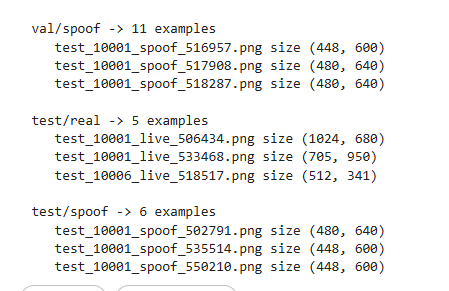

In [ ]:



import os, math, random, itertools
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
print("TensorFlow version:", tf.__version__)


# Data generators

In [ ]:
# Data generators (adjust BATCH or IMG_SIZE if you want)
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BASE = "/kaggle/working/dataset_sampled"
IMG_SIZE = (224,224)
BATCH = 16

train_dir = os.path.join(BASE, "train")
val_dir   = os.path.join(BASE, "val")
test_dir  = os.path.join(BASE, "test")

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.08,
                                   height_shift_range=0.08,
                                   shear_range=0.05,
                                   zoom_range=0.08,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir,
                                              target_size=IMG_SIZE,
                                              batch_size=BATCH,
                                              class_mode='binary',
                                              shuffle=True)

val_gen = val_datagen.flow_from_directory(val_dir,
                                          target_size=IMG_SIZE,
                                          batch_size=BATCH,
                                          class_mode='binary',
                                          shuffle=False)

test_gen = val_datagen.flow_from_directory(test_dir,
                                          target_size=IMG_SIZE,
                                          batch_size=1,
                                          class_mode='binary',
                                          shuffle=False)

print("Train samples:", train_gen.samples, "Val samples:", val_gen.samples, "Test samples:", test_gen.samples)
print("Class indices:", train_gen.class_indices)


# Build MobileNetV2 model

In [ ]:
# Build MobileNetV2 transfer model (freeze base initially)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0],IMG_SIZE[1],3))
x = GlobalAveragePooling2D()(base.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
out = Dense(1, activation='sigmoid')(x)
model = Model(base.input, out)

# Freeze base
for layer in base.layers:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


# Callbacks + Train

In [ ]:

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

ckpt_path = "/kaggle/working/antispoof_mobilenet_best.h5"
callbacks = [
    ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
]

EPOCHS = 8
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=EPOCHS,
                    callbacks=callbacks)


# Optional fine-tune

In [ ]:

for layer in base.layers[-40:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_ft = model.fit(train_gen, validation_data=val_gen, epochs=6, callbacks=callbacks)


# Evaluate on test set + classification report

In [ ]:

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

if os.path.exists(ckpt_path):
    model = load_model(ckpt_path)

preds = model.predict(test_gen, verbose=1)
y_pred = (preds.ravel() > 0.5).astype(int)
y_true = test_gen.classes

print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(test_gen.class_indices.keys()), yticklabels=list(test_gen.class_indices.keys()))
plt.xlabel("Pred"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()


# Quick Grad-CAM visual (optional)

In [ ]:

import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image as kimage
from pathlib import Path
import matplotlib.pyplot as plt

# Ensure 'model' exists (it will if you trained or loaded checkpoint)
try:
    model  # noqa
except NameError:
    raise RuntimeError("Model variable not found. Load or train the model first (run the training / load checkpoint cell).")

# 1) Safely find a last convolutional layer
last_conv = None
for l in reversed(model.layers):
    try:
        shape = getattr(l, "output_shape", None)
        # some layers expose output_shape as a tuple, some as list; guard with try/except
        if shape is None:
            # try to inspect output attribute (Tensor) if available
            out = getattr(l, "output", None)
            if out is not None:
                # out.shape is TensorShape
                shape = getattr(out, "shape", None)
        if shape is not None:
            # convert TensorShape to tuple if needed
            try:
                if hasattr(shape, "as_list"):
                    shp = shape.as_list()
                else:
                    shp = tuple(shape)
            except Exception:
                shp = None
            if shp and len(shp) == 4:
                last_conv = l.name
                break
    except Exception:
        # ignore layers that don't provide shape info
        continue

# Fallbacks if last_conv still None (common MobileNetV2 conv names)
if last_conv is None:
    for candidate in ["Conv_1", "conv_pw_13_relu", "block_16_project", "block_13_expand", "block_16_expand"]:
        try:
            if any(x.name == candidate for x in model.layers):
                last_conv = candidate
                break
        except Exception:
            continue

if last_conv is None:
    # As a last resort choose the last layer that has a 4D output tensor by checking output.shape
    for l in reversed(model.layers):
        try:
            out = getattr(l, "output", None)
            if out is None: 
                continue
            shp = getattr(out, "shape", None)
            if shp is None:
                continue
            # TensorShape -> list
            try:
                shp_list = shp.as_list()
            except Exception:
                shp_list = tuple(shp)
            if shp_list and len(shp_list) == 4:
                last_conv = l.name
                break
        except Exception:
            continue

if last_conv is None:
    raise RuntimeError("Could not find a convolutional layer automatically. Please tell me the model architecture or pick a conv layer name manually.")

print("Using last conv layer:", last_conv)

# 2) Grad-CAM function (works for binary output with sigmoid)
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, eps=1e-8):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        # preds shape: (1,1) for binary. Use preds[:,0] as loss.
        loss = preds[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    # If grads is None (rare), return zeros
    if grads is None:
        return np.zeros(shape=(conv_outputs.shape[1], conv_outputs.shape[2]), dtype=np.float32)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    denom = tf.math.reduce_max(heatmap) + eps
    heatmap = heatmap / denom
    return heatmap.numpy()

# 3) Prepare sample test images (up to 6) from your test folder
TEST_ROOT = Path("/kaggle/working/dataset_sampled/test")
IMG_SIZE = (224, 224)  # should match training IMG_SIZE

samples = []
for lbl in ("real", "spoof"):
    p = TEST_ROOT / lbl
    if not p.exists():
        continue
    for f in sorted(p.glob("*"))[:3]:
        samples.append((str(f), lbl))
# if no samples found, try dataset_quick or dataset folders
if not samples:
    alt = Path("/kaggle/working/dataset_quick")
    for lbl in ("real","spoof"):
        p = alt / "train" / lbl
        if p.exists():
            for f in sorted(p.glob("*"))[:3]:
                samples.append((str(f), lbl))

if not samples:
    raise RuntimeError("No test images found in /kaggle/working/dataset_sampled/test. Check your dataset path.")

# 4) Compute Grad-CAM and display
plt.figure(figsize=(12, 8))
for idx, (fp, label) in enumerate(samples[:6]):
    img = kimage.load_img(fp, target_size=IMG_SIZE)
    x = kimage.img_to_array(img) / 255.0
    x_exp = np.expand_dims(x, axis=0).astype(np.float32)

    # prediction
    pred = float(model.predict(x_exp, verbose=0).ravel()[0])

    # heatmap
    heatmap = make_gradcam_heatmap(x_exp, model, last_conv)

    # upsample heatmap to image size and apply color
    heat = cv2.resize((heatmap * 255).astype(np.uint8), (IMG_SIZE[1], IMG_SIZE[0]))
    heat = cv2.applyColorMap(heat, cv2.COLORMAP_JET)
    img_rgb = (x * 255).astype(np.uint8)
    superimposed = cv2.addWeighted(img_rgb, 0.6, heat, 0.4, 0)

    plt.subplot(3, 2, idx + 1)
    plt.imshow(superimposed.astype(np.uint8))
    plt.title(f"{label} — pred:{pred:.3f}")
    plt.axis("off")

plt.tight_layout()
plt.show()


**Save Grad-CAM images to disk**

In [ ]:
# Save Grad-CAM images to disk
import numpy as np, cv2, os
from tensorflow.keras.preprocessing import image as kimage
from pathlib import Path

OUT = Path("/kaggle/working/gradcam_outputs")
OUT.mkdir(parents=True, exist_ok=True)

# reuse make_gradcam_heatmap() and last_conv from your notebook
# sample images
test_root = Path("/kaggle/working/dataset_sampled/test")
samples = []
for lbl in ("real","spoof"):
    p = test_root / lbl
    for f in sorted(p.glob("*"))[:3]:
        samples.append((str(f), lbl))

for idx,(fp,label) in enumerate(samples[:12]):
    img = kimage.load_img(fp, target_size=(224,224))
    x = kimage.img_to_array(img)/255.0
    x_exp = np.expand_dims(x, axis=0).astype(np.float32)
    pred = float(model.predict(x_exp).ravel()[0])
    heatmap = make_gradcam_heatmap(x_exp, model, last_conv)
    heat = cv2.resize((heatmap*255).astype(np.uint8), (224,224))
    heat = cv2.applyColorMap(heat, cv2.COLORMAP_JET)
    img_rgb = (x*255).astype(np.uint8)
    superimposed = cv2.addWeighted(img_rgb, 0.6, heat, 0.4, 0)
    outp = OUT / f"gradcam_{idx}_{label}_pred{pred:.3f}.png"
    cv2.imwrite(str(outp), cv2.cvtColor(superimposed, cv2.COLOR_RGB2BGR))
print("Saved gradcam images to:", OUT)


# Face-detection cropping (Haar) — creates /kaggle/working/dataset_crops

In [ ]:


import cv2, os
from pathlib import Path
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

SRC_ROOT = Path("/kaggle/working/dataset_sampled")
OUT_ROOT = Path("/kaggle/working/dataset_crops")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

haar_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
detector = cv2.CascadeClassifier(haar_path)
print("Using Haar cascade:", haar_path)

def crop_and_save(src_path, dst_path, size=(224,224)):
    img = cv2.imread(str(src_path))
    if img is None:
        return False
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # detect faces (scaleFactor & minNeighbors tuned for variety)
    faces = detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4, minSize=(30,30))
    if len(faces) == 0:
        # fallback: try a larger window or center-crop if no face found
        h,w = img.shape[:2]
        min_side = min(h,w)
        cx,cy = w//2, h//2
        half = min_side//2
        x = max(0, cx-half); y = max(0, cy-half)
        crop = img[y:y+2*half, x:x+2*half]
    else:
        # pick largest face
        x,y,w,h = max(faces, key=lambda r: r[2]*r[3])
        pad = int(0.25 * max(w,h))  # small padding
        x1 = max(0, x - pad); y1 = max(0, y - pad)
        x2 = min(img.shape[1], x + w + pad); y2 = min(img.shape[0], y + h + pad)
        crop = img[y1:y2, x1:x2]

    try:
        crop = cv2.resize(crop, size)
    except Exception:
        return False
    dst_path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(dst_path), crop)
    return True

# iterate splits and labels
total = 0
failed = 0
for split in ["train","val","test"]:
    for label in ["real","spoof"]:
        src_dir = SRC_ROOT / split / label
        out_dir = OUT_ROOT / split / label
        out_dir.mkdir(parents=True, exist_ok=True)
        if not src_dir.exists(): 
            continue
        for p in sorted(src_dir.glob("*")):
            out_p = out_dir / p.name
            ok = crop_and_save(p, out_p)
            total += 1
            if not ok:
                failed += 1
print(f"Cropped images saved under {OUT_ROOT}  (total processed: {total}, failed: {failed})")
# quick counts
for split in ["train","val","test"]:
    for label in ["real","spoof"]:
        print(f"{split}/{label} ->", len(list((OUT_ROOT/split/label).glob("*"))))


**Batch inference + Grad-CAM + CSV results**

In [ ]:

import numpy as np, os, cv2, math
from pathlib import Path
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as kimage
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# CONFIG
MODEL_PATH = "/kaggle/working/antispoof_mobilenet_best.h5"  # change if different
CROP_ROOT = Path("/kaggle/working/dataset_crops/test")
OUT_DIR = Path("/kaggle/working/gradcam_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
IMG_SIZE = (224,224)

# load model (best checkpoint)
if not Path(MODEL_PATH).exists():
    raise FileNotFoundError(f"Model not found at {MODEL_PATH} — save checkpoint or adjust MODEL_PATH.")
model = load_model(MODEL_PATH)
print("Model loaded:", MODEL_PATH)

# find last conv layer robustly
last_conv = None
for l in reversed(model.layers):
    shp = getattr(l, "output_shape", None)
    if shp is None:
        out = getattr(l, "output", None)
        if out is not None:
            shp = getattr(out, "shape", None)
    try:
        if shp is not None:
            # convert to list
            if hasattr(shp, "as_list"):
                shp_list = shp.as_list()
            else:
                shp_list = tuple(shp)
            if shp_list and len(shp_list) == 4:
                last_conv = l.name
                break
    except Exception:
        continue
if last_conv is None:
    raise RuntimeError("Could not find conv layer automatically. Provide model.summary() output.")
print("Using last conv layer:", last_conv)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, eps=1e-8):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        loss = preds[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    if grads is None:
        return np.zeros((conv_outputs.shape[1], conv_outputs.shape[2]), dtype=np.float32)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    denom = tf.math.reduce_max(heatmap) + eps
    heatmap = heatmap / denom
    return heatmap.numpy()

results = []
y_true, y_pred_scores = [], []
test_images = []

for label in ("real","spoof"):
    folder = CROP_ROOT / label
    if not folder.exists(): continue
    for fp in sorted(folder.glob("*")):
        try:
            img = kimage.load_img(fp, target_size=IMG_SIZE)
            x = kimage.img_to_array(img) / 255.0
            x_exp = np.expand_dims(x, axis=0).astype(np.float32)
            score = float(model.predict(x_exp, verbose=0).ravel()[0])  # sigmoid score
            pred_class = 1 if score>0.5 else 0
            results.append({"path": str(fp), "true": label, "true_bin": 1 if label=="spoof" else 0, "score": score, "pred": pred_class})
            y_true.append(1 if label=="spoof" else 0)
            y_pred_scores.append(score)
            test_images.append(fp)
        except Exception as e:
            print("Skipping", fp, "->", e)

# Save CSV
df = pd.DataFrame(results)
out_csv = Path("/kaggle/working/predictions.csv")
df.to_csv(out_csv, index=False)
print("Predictions saved to", out_csv)
print("Total predicted:", len(df))

# Confusion matrix & classification report
if len(df)==0:
    raise RuntimeError("No predictions were made; check CROP_ROOT path: " + str(CROP_ROOT))

y_true_arr = df["true_bin"].values
y_pred_bin = (df["score"].values > 0.5).astype(int)
print("\nClassification report:")
print(classification_report(y_true_arr, y_pred_bin, target_names=["real","spoof"]))

cm = confusion_matrix(y_true_arr, y_pred_bin)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["real","spoof"], yticklabels=["real","spoof"])
plt.xlabel("Pred"); plt.ylabel("True"); plt.title("Confusion Matrix"); plt.show()

# Generate and save Grad-CAM images for top-K sample images (K=12)
K = 12
for idx, row in df.sort_values("score", ascending=False).head(K).iterrows():
    fp = Path(row["path"])
    img = kimage.load_img(fp, target_size=IMG_SIZE)
    x = kimage.img_to_array(img) / 255.0
    x_exp = np.expand_dims(x, axis=0).astype(np.float32)
    heatmap = make_gradcam_heatmap(x_exp, model, last_conv)
    heat = cv2.resize((heatmap*255).astype(np.uint8), (IMG_SIZE[1], IMG_SIZE[0]))
    heat = cv2.applyColorMap(heat, cv2.COLORMAP_JET)
    img_rgb = (x*255).astype(np.uint8)
    superimposed = cv2.addWeighted(img_rgb, 0.6, heat, 0.4, 0)
    outp = OUT_DIR / f"gradcam_top_{idx}_{fp.name}_score{row['score']:.3f}.png"
    cv2.imwrite(str(outp), cv2.cvtColor(superimposed, cv2.COLOR_RGB2BGR))

print("Saved Grad-CAM images to:", OUT_DIR)


**RESAMPLE with larger N_PER_CLASS + retrain**

In [ ]:

from pathlib import Path
import shutil, random, os
SRC_CELEBA = Path("/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data")
SRC_PRINT = Path("/kaggle/input/photo-print-attacks-dataset-1k-individuals")
DST = Path("/kaggle/working/dataset_sampled_big")

N_PER_CLASS = 1000   # set 600 or 400 if you have runtime concerns; 1000 gives better results
if DST.exists():
    print("Removing old folder", DST)
    shutil.rmtree(DST)
for split in ("train","val","test"):
    for lbl in ("real","spoof"):
        (DST/split/lbl).mkdir(parents=True, exist_ok=True)

def detect_label_from_path(p:Path):
    s = str(p).lower()
    if any(k in s for k in ("live","real","genuine")): return "real"
    if any(k in s for k in ("spoof","attack","print","replay","photo","display","screen","fake")): return "spoof"
    return None

# Helper: fast gather limited items per label from a source root by searching limited depth
def sample_from_root(root, n_per=N_PER_CLASS):
    found = {"real":0,"spoof":0}
    if not root.exists(): return found
    # target pattern walking that matches the structure; sample without scanning everything
    # iterate top-level children, then their subfolders
    for a in sorted(root.iterdir()):
        if found["real"]>=n_per and found["spoof"]>=n_per:
            break
        for b in sorted(a.rglob("*")):
            if found["real"]>=n_per and found["spoof"]>=n_per:
                break
            if b.is_file() and b.suffix.lower() in (".jpg",".jpeg",".png"):
                lbl = detect_label_from_path(b)
                if lbl is None:
                    # fallback: treat as real if no spoof keywords
                    lbl = "real"
                if found[lbl] < n_per:
                    # place into train/val/test randomly
                    r = random.random()
                    if r < 0.7: split="train"
                    elif r < 0.85: split="val"
                    else: split="test"
                    dst = DST/split/lbl/b.name
                    try:
                        shutil.copy(b, dst)
                        found[lbl] += 1
                    except Exception:
                        pass
    return found

print("Sampling from CelebA (may take a little time)...")
c1 = sample_from_root(SRC_CELEBA, N_PER_CLASS)
print("CelebA counts:", c1)
print("Sampling from Photo-Print (may be smaller)...")
c2 = sample_from_root(SRC_PRINT, N_PER_CLASS//2)  # PhotoPrint smaller — take fewer
print("Photo-Print counts:", c2)

# quick summary
for split in ("train","val","test"):
    print(split, "-> real:", len(list((DST/split/"real").glob("*"))), "spoof:", len(list((DST/split/"spoof").glob("*"))))


**Training cell tuned for bigger dataset**

In [ ]:
# Training with stronger augmentation + focal loss option
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

BASE = "/kaggle/working/dataset_sampled_big"
IMG_SIZE=(224,224)
BATCH=32

# stronger augmentation: add gaussian noise & jpeg corruption via preprocessing_function
import numpy as np
import cv2
def random_augment(img):
    # img: float32 array [0,1]
    # random gaussian blur
    if np.random.rand() < 0.3:
        k = np.random.choice([3,5])
        img = cv2.GaussianBlur((img*255).astype(np.uint8), (k,k), 0)/255.0
    # jpeg compression
    if np.random.rand() < 0.2:
        encode = cv2.imencode('.jpg', (img*255).astype(np.uint8), [int(cv2.IMWRITE_JPEG_QUALITY), np.random.randint(30,90)])[1]
        img = cv2.imdecode(encode, cv2.IMREAD_COLOR)[:,:,::-1]/255.0
    # random brightness
    if np.random.rand() < 0.3:
        factor = 0.7 + np.random.rand()*0.6
        img = np.clip(img * factor, 0, 1)
    # add noise
    if np.random.rand() < 0.2:
        img = np.clip(img + np.random.normal(scale=0.02, size=img.shape), 0, 1)
    return img

# wrapper for ImageDataGenerator preprocessing (expects 0-255 uint image)
def preprocess_fn(x):
    x = x.astype(np.float32)/255.0
    x = random_augment(x)
    return x

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_fn,
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255.0)

train_gen = train_datagen.flow_from_directory(os.path.join(BASE,"train"), target_size=IMG_SIZE, batch_size=BATCH, class_mode='binary', shuffle=True)
val_gen   = val_datagen.flow_from_directory(os.path.join(BASE,"val"), target_size=IMG_SIZE, batch_size=BATCH, class_mode='binary', shuffle=False)

# build model
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0],IMG_SIZE[1],3))
x = GlobalAveragePooling2D()(base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid')(x)
model = Model(base.input, out)
for layer in base.layers:
    layer.trainable=False

# optional focal loss (uncomment if desired)
# def focal_loss(gamma=2., alpha=.25):
#     def fl(y_true, y_pred):
#         y_pred = tf.keras.backend.clip(y_pred, 1e-7, 1-1e-7)
#         pt = tf.where(tf.equal(y_true,1), y_pred, 1-y_pred)
#         return -alpha * tf.keras.backend.pow(1-pt, gamma) * tf.keras.backend.log(pt)
#     return fl
# loss = focal_loss()
loss = 'binary_crossentropy'

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=loss, metrics=['accuracy'])

ckpt = "/kaggle/working/antispoof_big_mobilenet_best.h5"
callbacks=[ModelCheckpoint(ckpt, monitor='val_accuracy', save_best_only=True, verbose=1),
           ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
           EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)]

EPOCHS=20
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=callbacks)


# Evaluate on test set

In [ ]:
# EVAL CELL: classification report, confusion matrix, ROC/AUC, save preds CSV
import os, numpy as np, pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt, seaborn as sns

CKPT = "/kaggle/working/antispoof_big_mobilenet_best.h5"   
BASE = "/kaggle/working/dataset_sampled_big"               
IMG_SIZE = (224,224)

if not os.path.exists(CKPT):
    print("Checkpoint not found at", CKPT)
else:
    model = load_model(CKPT)
    print("Loaded model:", CKPT)

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_gen = test_datagen.flow_from_directory(os.path.join(BASE,"test"),
                                                target_size=IMG_SIZE, batch_size=1,
                                                class_mode='binary', shuffle=False)
    preds = model.predict(test_gen, verbose=1)
    scores = preds.ravel()
    y_true = test_gen.classes
    y_pred = (scores > 0.5).astype(int)

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(test_gen.class_indices.keys()), yticklabels=list(test_gen.class_indices.keys()))
    plt.xlabel("Pred"); plt.ylabel("True"); plt.title("Confusion matrix")
    plt.show()

    # ROC / AUC
    try:
        auc = roc_auc_score(y_true, scores)
        fpr, tpr, thr = roc_curve(y_true, scores)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC")
        plt.legend(); plt.show()
        print("AUC:", auc)
    except Exception as e:
        print("Could not compute ROC/AUC:", e)

    # Save predictions CSV
    fnames = np.array(test_gen.filenames)
    df = pd.DataFrame({"filename": fnames, "true": y_true, "score": scores, "pred": y_pred})
    df.to_csv("/kaggle/working/predictions_test.csv", index=False)
    print("Saved predictions to /kaggle/working/predictions_test.csv")


# Compute EER & ACER

In [ ]:
# EER & ACER cell
import numpy as np
from sklearn.metrics import roc_curve

# expects y_true (0=real,1=spoof) and scores (higher -> more spoof)
# If you ran the eval cell just above, y_true and scores are in memory.

def eer_from_scores(y_true, scores):
    fpr, tpr, thresholds = roc_curve(y_true, scores)
    fnr = 1 - tpr
    idx = np.nanargmin(np.abs(fpr - fnr))
    eer = (fpr[idx] + fnr[idx]) / 2.0
    return eer, thresholds[idx], fpr, tpr

eer, thr_eer, fpr, tpr = eer_from_scores(y_true, scores)
print("EER (approx):", eer, "threshold at EER:", thr_eer)

# ACER calculation at chosen threshold (use thr_eer or 0.5)
threshold = thr_eer  # or 0.5
y_pred_thr = (scores >= threshold).astype(int)
APCER = np.sum((y_true==1) & (y_pred_thr==0)) / np.sum(y_true==1)  # spoof classified as bona fide? adjust mapping if needed
NPCER = np.sum((y_true==0) & (y_pred_thr==1)) / np.sum(y_true==0)
ACER = (APCER + NPCER)/2.0
print(f"ACER @ threshold {threshold:.4f}: APCER={APCER:.4f}, NPCER={NPCER:.4f}, ACER={ACER:.4f}")


**Save Grad-CAM images for top-K (visual inspection)**

# 

In [ ]:

import os, cv2, numpy as np, pandas as pd, tensorflow as tf
from pathlib import Path
from tensorflow.keras.preprocessing import image as kimage
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# CONFIG: possible test roots to try (order matters)
possible_roots = [
    Path("/kaggle/working/dataset_sampled_big/test"),
    Path("/kaggle/working/dataset_sampled/test"),
    Path("/kaggle/working/dataset_quick/test"),
    Path("/kaggle/working/dataset_sampled/test"),
    Path("/kaggle/working/dataset_crops/test"),
    Path("/kaggle/working/dataset/test")
]

# 1) Load predictions DataFrame (from memory or CSV)
if "df" in globals():
    df_preds = df.copy()
elif Path("/kaggle/working/predictions_test.csv").exists():
    df_preds = pd.read_csv("/kaggle/working/predictions_test.csv")
elif Path("/kaggle/working/predictions.csv").exists():
    df_preds = pd.read_csv("/kaggle/working/predictions.csv")
else:
    raise FileNotFoundError("predictions_test.csv not found in /kaggle/working and df not present in memory.")

# 2) Determine test root automatically
test_root = None
for p in possible_roots:
    if p.exists():
        # ensure it contains some images / folders
        try:
            files = list(p.rglob("*"))
            if any(str(f.suffix).lower() in (".jpg",".jpeg",".png") for f in files[:10]):
                test_root = p
                break
        except Exception:
            continue

if test_root is None:
    print("Could not auto-detect test root from common locations. Please set TEST_ROOT manually.")
    print("Tried:", [str(x) for x in possible_roots])
    raise RuntimeError("Test root not found. If your test images are somewhere else, set TEST_ROOT variable to that folder.")

print("Detected test root:", test_root)

# 3) Ensure model is loaded (tries to use 'model' if present; otherwise loads checkpoint)
if 'model' not in globals():
    CKPT = "/kaggle/working/antispoof_big_mobilenet_best.h5"
    if not Path(CKPT).exists():
        # try other likely names
        for alt in ["antispoof_mobilenet_best.h5", "antispoof_mobilenet_final.h5", "antispoof_mobilenet_best.h5", "antispoof_mobilenet.h5"]:
            if Path("/kaggle/working")/alt .exists():
                CKPT = str(Path("/kaggle/working")/alt)
                break
    if not Path(CKPT).exists():
        raise FileNotFoundError("Model 'model' not in memory and no checkpoint found in /kaggle/working/. Please set CKPT path.")
    print("Loading model from:", CKPT)
    model = tf.keras.models.load_model(CKPT)

# 4) find last conv layer robustly
last_conv = None
for l in reversed(model.layers):
    try:
        shp = getattr(l, "output_shape", None)
        if shp is None and getattr(l, "output", None) is not None:
            shp = l.output.shape
        if shp is not None:
            if hasattr(shp, "as_list"):
                shp_list = shp.as_list()
            else:
                shp_list = tuple(shp)
            if shp_list and len(shp_list) == 4:
                last_conv = l.name
                break
    except Exception:
        continue
if last_conv is None:
    raise RuntimeError("Could not determine last conv layer automatically. Provide model.summary() to pick a conv layer name.")
print("Using last conv layer:", last_conv)

# 5) Grad-CAM helper
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, eps=1e-8):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        loss = preds[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    if grads is None:
        return np.zeros((conv_outputs.shape[1], conv_outputs.shape[2]), dtype=np.float32)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    denom = tf.math.reduce_max(heatmap) + eps
    heatmap = heatmap / denom
    return heatmap.numpy()

# 6) Prepare outputs and selection
OUT = Path("/kaggle/working/gradcam_inspect")
OUT.mkdir(parents=True, exist_ok=True)

# If df contains relative filenames (like 'spoof/498220.png'), use test_root/fname
fn_col = None
# locate filename-like column
for c in ["filename","path","file","img","image"]:
    if c in df_preds.columns:
        fn_col = c; break
if fn_col is None:
    # fallback: take first column
    fn_col = df_preds.columns[0]

# Normalize filenames into absolute paths
abs_paths = []
not_found = []
for idx, row in df_preds.iterrows():
    raw = str(row[fn_col])
    # if already absolute and exists -> use it
    p = Path(raw)
    if p.exists():
        abs_paths.append(str(p))
        continue
    # try join with test_root
    candidate = test_root / raw
    if candidate.exists():
        abs_paths.append(str(candidate))
        continue
    # sometimes filenames are stored as 'real/xxx' but nested under dataset_sampled_big/test/real/xxx
    candidate2 = test_root / Path(raw).name  # only filename
    if candidate2.exists():
        abs_paths.append(str(candidate2)); continue
    # try other depth: if raw is like 'spoof/498220.png' and dataset root is higher, try test_root.parent / raw
    candidate3 = test_root.parent / raw
    if candidate3.exists():
        abs_paths.append(str(candidate3)); continue
    # else mark not found
    abs_paths.append(None)
    not_found.append(raw)

# attach resolved paths to df
df_preds["_abs_path"] = abs_paths

print(f"Total predictions: {len(df_preds)}, not found entries: {len([x for x in abs_paths if x is None])}")

# 7) Select top-K spoof and top-K real (by score) - handle column names
score_col = None
for c in ["score","pred_score","prob","probability"]:
    if c in df_preds.columns:
        score_col = c; break
if score_col is None:
    # fallback to second numeric column
    numeric_cols = df_preds.select_dtypes(include=[np.number]).columns.tolist()
    score_col = numeric_cols[0] if numeric_cols else None
if score_col is None:
    raise RuntimeError("Cannot find score column in predictions dataframe.")

# choose K
K = 12
top_spoof = df_preds.sort_values(score_col, ascending=False).head(K)
top_real  = df_preds.sort_values(score_col, ascending=True).head(K)

# 8) Save cams (robust)
def save_cam_row(row, tag):
    ap = row["_abs_path"]
    if ap is None or not Path(ap).exists():
        print("Missing file, skipping:", row.get(fn_col, "(no name)"))
        return False
    try:
        img = kimage.load_img(ap, target_size=(224,224))
        x = kimage.img_to_array(img)/255.0
        x_exp = np.expand_dims(x, axis=0).astype(np.float32)
        score = float(model.predict(x_exp, verbose=0).ravel()[0])
        heatmap = make_gradcam_heatmap(x_exp, model, last_conv)
        heat = cv2.resize((heatmap*255).astype(np.uint8), (224,224))
        heat = cv2.applyColorMap(heat, cv2.COLORMAP_JET)
        img_rgb = (x*255).astype(np.uint8)
        sup = cv2.addWeighted(img_rgb, 0.6, heat, 0.4, 0)
        outp = OUT / f"{tag}_{Path(ap).stem}_score{score:.3f}.png"
        cv2.imwrite(str(outp), cv2.cvtColor(sup, cv2.COLOR_RGB2BGR))
        return True
    except Exception as e:
        print("Error processing", ap, "->", e)
        return False

count_saved = 0
for _, r in top_spoof.iterrows():
    if save_cam_row(r, "top_spoof"):
        count_saved += 1
for _, r in top_real.iterrows():
    if save_cam_row(r, "top_real"):
        count_saved += 1

print(f"Done. Saved {count_saved} Grad-CAM images to {OUT}")
if len(not_found)>0:
    print("Some filenames were not found (examples):", not_found[:10])
    print("If you see many missing files, please confirm the test root, or provide the exact path used by your generator.")


# View a few saved Grad-CAMs inside the notebook

In [ ]:
from IPython.display import display
from PIL import Image
from pathlib import Path
p = Path("/kaggle/working/gradcam_inspect")
imgs = sorted(list(p.glob("*.png")))[:8]
print("Showing", len(imgs), "images from", p)
for im in imgs:
    display(Image.open(im).resize((400,400)))


# Create a ZIP of all outputs (model, preds CSV, gradcams) for download

In [ ]:
%%bash
cd /kaggle/working
zip -r antispoof_outputs.zip antispoof_big_mobilenet_best.h5 predictions_test.csv gradcam_inspect gradcam_outputs || true
ls -lh antispoof_outputs.zip


**Print short numeric summary from predictions (per-class AP/NP error / counts)**

In [ ]:
import pandas as pd, numpy as np
df = pd.read_csv("/kaggle/working/predictions_test.csv")
print(df.head())
# mapping: assume true: 1==spoof, 0==real (if different, swap)
total = len(df)
print("Total test samples:", total)
print("Counts by true label:\n", df['true'].value_counts())
# small summary by threshold 0.5
df['pred']= (df['score']>0.5).astype(int)
tp = ((df['true']==1)&(df['pred']==1)).sum()
tn = ((df['true']==0)&(df['pred']==0)).sum()
fp = ((df['true']==0)&(df['pred']==1)).sum()
fn = ((df['true']==1)&(df['pred']==0)).sum()
print("TP, TN, FP, FN:", tp, tn, fp, fn)


**Tune a threshold using EER & save thresholded preds**

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve
df = pd.read_csv("/kaggle/working/predictions_test.csv")
y = df['true'].values
scores = df['score'].values
fpr,tpr,thr = roc_curve(y,scores)
fnr = 1 - tpr
idx = np.nanargmin(np.abs(fpr - fnr))
eer_thr = thr[idx]
print("EER threshold:", eer_thr)
df['pred_eer'] = (df['score'] >= eer_thr).astype(int)
df.to_csv("/kaggle/working/predictions_test_with_eer.csv", index=False)
print("Saved predictions with EER-threshold to predictions_test_with_eer.csv")
